# Transfer Learning Using Pretrained ConvNets

https://www.tensorflow.org/beta/tutorials/images/transfer_learning

In [11]:
from __future__ import absolute_import, division, print_function, unicode_literals

#!pip install -q tensorflow==2.0.0-beta1
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print(tf.__version__)

2.0.0-beta1


### Data download
Use TensorFlow Datasets to load the cats and dogs dataset.<br><br>

This tfds package is the easiest way to load pre-defined data. If you have your own data, and are interested in importing using it with TensorFlow see loading image data

In [36]:
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)


In [37]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs', split=list(splits),
    with_info=True, as_supervised=True)

In [38]:
print(raw_train)
print(raw_validation)
print(raw_test)

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


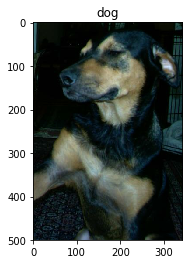

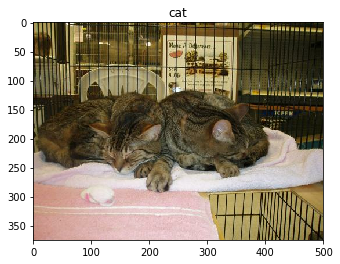

In [39]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

# Format the data

Use the tf.image module to format the images for the task.

Resize the images to a fixes input size, and rescale the input channels to a range of [-1,1]

In [8]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [42]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

Now shuffle and batch the data.

In [43]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 160, 160, 3])

# Create the base model from the pre-trained convnets

You will create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images. ImageNet has a fairly arbitrary research training dataset with categories like jackfruit and syringe, but this base of knowledge will help us tell apart cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. Obviously, the very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to instead depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck features retain much generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [19]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each 160x160x3 image to a 5x5x1280 block of features. See what it does to the example batch of images:

In [20]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


Feature extraction
You will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

Freeze the convolutional base
It's important to freeze the convolutional based before you compile and train the model. By freezing (or setting layer.trainable = False), you prevent the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all the layers.

In [21]:
base_model.trainable = False
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

## Add a classification head
To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)



(32, 1280)


Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [23]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Now stack the feature extractor, and these two layers using a tf.keras.Sequential model:

In [24]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [25]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


The 2.5M parameters in MobileNet are frozen, but there are 1.2K trainable parameters in the Dense layer. These are divided between two tf.Variable objects, the weights and biases.

In [26]:
len(model.trainable_variables)

2

# Train the model

In [46]:
num_train, num_val, num_test = (
  metadata.splits['train'].num_examples*weight/10
  for weight in SPLIT_WEIGHTS
)

initial_epochs = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

NameError: name 'model' is not defined

In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))



initial loss: 5.70
initial accuracy: 0.55


In [29]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10


W0616 10:15:05.981739 4707894720 deprecation.py:323] From /Users/yhollander/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


582/582 [==============================] - 499s 857ms/step - loss: 2.6269 - accuracy: 0.6928 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
582/582 [==============================] - 457s 785ms/step - loss: 1.2030 - accuracy: 0.8450 - val_loss: 0.8858 - val_accuracy: 0.8966
Epoch 3/10
582/582 [==============================] - 444s 764ms/step - loss: 0.8196 - accuracy: 0.8898 - val_loss: 0.5693 - val_accuracy: 0.9259
Epoch 4/10
582/582 [==============================] - 459s 788ms/step - loss: 0.6576 - accuracy: 0.9096 - val_loss: 0.5350 - val_accuracy: 0.9358
Epoch 5/10
582/582 [==============================] - 405s 696ms/step - loss: 0.5686 - accuracy: 0.9220 - val_loss: 0.4915 - val_accuracy: 0.9388
Epoch 6/10
582/582 [==============================] - 439s 754ms/step - loss: 0.5145 - accuracy: 0.9298 - val_loss: 0.4351 - val_accuracy: 0.9496
Epoch 7/10
582/582 [==============================] - 488s 838ms/step - loss: 0.4857 - accuracy: 0.9346 - val_loss: 0.4115 - va

# Learning curves

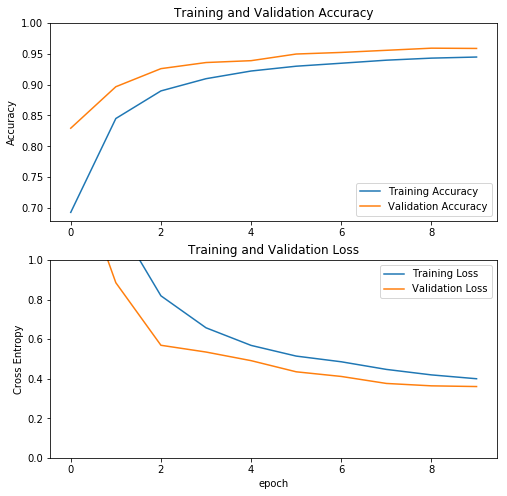

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

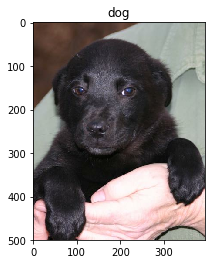

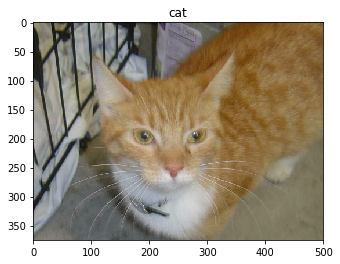

In [47]:
for image, label in raw_test.take(2):
    
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [44]:
model.save('my_model_1.h5')

# Recreate the model

In [30]:
# Recreate the exact same model, including weights and optimizer.
new_model = keras.models.load_model('my_model_1.h5')
new_model.summary()

W0618 15:07:24.635290 4733650368 deprecation.py:323] From /Users/yhollander/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [48]:
new_loss, new_accuracy = new_model.evaluate(validation_batches, steps = 20)
print("Restored model, accuracy: {:5.2f}%".format(100*new_accuracy))
print("Restored model, loss: {:5.2f}%".format(new_loss))

20/20 [==============================] - 14s 702ms/step - loss: 0.3869 - accuracy: 0.9609
Restored model, accuracy: 96.09%
Restored model, loss:  0.39%


# Predict

In [105]:
def get_prediction_label(probability):
    if(probability <=0):
        return "Cat"
    else:
        return "Dog"
    
def predict(test_image, test_label):
    x = image.img_to_array(test_image)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = new_model.predict(images, batch_size=1)
    plt.figure()
    plt.imshow(test_image)
    plt.title(test_label + "  -  " +  str(classes[0]))    

In [55]:
import tensorflow as tf
import numpy as np
import keras_preprocessing
from keras_preprocessing import image

W0618 15:30:06.647504 4733650368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0618 15:30:06.703459 4733650368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0618 15:30:06.774775 4733650368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


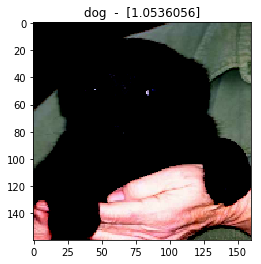

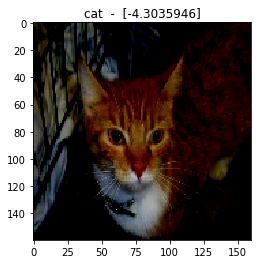

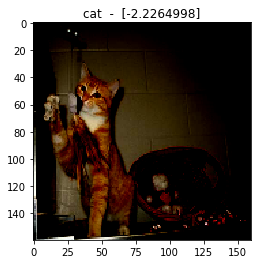

In [106]:
for test_image, test_label in test.take(3):
    predict(test_image, get_label_name(test_label))

In [72]:
import urllib.request 
FOLDER_NAME = "test_images"
url = "https://baobab-poseannotation-appfile.s3.amazonaws.com/media/project_5/images/images01/01418849d54b3005.o.1.jpg"
image_from_url = urllib.request.urlretrieve(url, FOLDER_NAME + "/test.jpg")

downloaded_image = mpimg.imread(image_from_url[0])
downloaded_label = image_from_url[0]




W0618 15:30:11.203934 4733650368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


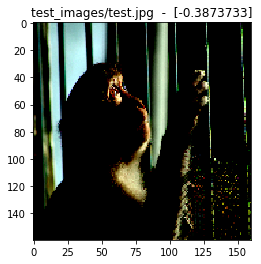

In [107]:

(test_image, test_label) = format_example(downloaded_image, downloaded_label)

predict(test_image, test_label)


In [109]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

open("catVsDogs_model.tflite", "wb").write(tflite_model)



8861160